***author: Bruno Guimarães de Oliveira***
***

#### Objectives:
- Create a model to forecast the quantity sold for each product given a prescribed price.

### Importing packages

In [199]:
#Data wrangling
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

#Configurations
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_rows=999
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Statistical and Time series analysis
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from fbprophet import Prophet
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

#Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit

#Operational System
import os

#Garbage collector
import gc
gc.enable()

#Filtering warnings
import warnings
warnings.filterwarnings('ignore')

### Reading data

Our first dataset sales.csv contains transactional information where each line represents a sale.

Features description:
- ***PROD_ID:** Product ID. (P1 to P9)
- ***DATE_ORDER:** Sales Date.
- ***QTY_ORDER:** Quantity sold. (Target)
- ***REVENUE:** Sale Revenue.

In [2]:
file_path = '../data/test_prc/'

In [3]:
sales = pd.read_csv(file_path + 'sales.csv', parse_dates=['DATE_ORDER'])

In [87]:
sales.head()

,prod_id,qty_order,revenue
date_order,,,
2015-01-01,P7,1.000,799.000
2015-01-01,P7,1.000,799.000
2015-01-01,P7,1.000,799.000
2015-01-01,P7,1.000,799.000
2015-01-01,P7,1.000,799.000


In [248]:
sales.shape

(348103, 6)

This dataset contains data of competitors' prices.

Features description:

- ***DATE_EXTRACTION:*** Date and Time of the extraction of the competitors' price.
- ***PROD_ID:*** Product ID. (Same as the sales dataset)
- ***COMPETITOR:*** Competitors' ID. (C1 to C6)
- ***COMPETITOR_PRICE:*** Competitor's price per product, which can depend on the payment method.
- ***PAY_TYPE:*** Payment Method. (1=deferred payment, 2=immediate payment)

In [4]:
prices = pd.read_csv(file_path + 'comp_prices.csv', parse_dates=['DATE_EXTRACTION'])

In [88]:
prices.head()

,prod_id,competitor,competitor_price,pay_type
date_extraction,,,,
2015-01-01 08:10:25,P7,C4,799.000,1
2015-01-01 08:10:25,P6,C6,2799.900,1
2015-01-01 08:10:25,P6,C1,1959.900,1
2015-01-01 08:10:25,P6,C3,1914.900,1
2015-01-01 08:10:25,P6,C1,1959.900,2


In [249]:
prices.shape

(50038, 4)

Now we normalize the columns putting all in lowercase, put the date feature on index and them sort the index of both datasets:

In [6]:
sales.columns = sales.columns.str.lower()
prices.columns = prices.columns.str.lower()

sales.set_index(sales['date_order'], inplace=True)
sales.drop('date_order', axis=1, inplace=True)
prices.set_index(prices['date_extraction'], inplace=True)
prices.drop('date_extraction', axis=1, inplace=True)

sales.sort_index(inplace=True)
prices.sort_index(inplace=True)

In [7]:
# convert_features(sales)
# convert_features(prices, 'prices')

First things first, we start by analysing the sales dataset to see if we can find some knowledge from there, then we pass to the competitors' prices dataset and finally we figure out a way of join both of datasets (probably we join then by prod_id, because is the only feature in common) and search for some correlations on the data. 

Let's give a first look on sales data.

In [8]:
prices.head()

,prod_id,competitor,competitor_price,pay_type
date_extraction,,,,
2015-01-01 08:10:25,P7,C4,799.000,1
2015-01-01 08:10:25,P6,C6,2799.900,1
2015-01-01 08:10:25,P6,C1,1959.900,1
2015-01-01 08:10:25,P6,C3,1914.900,1
2015-01-01 08:10:25,P6,C1,1959.900,2


In [9]:
print('Sales date range from {} to {}'.format(sales.index.min(), sales.index.max()))
print("Competitors' prices date range from {} to {}".format(prices.index.min(), prices.index.max()))

Sales date range from 2015-01-01 00:00:00 to 2015-10-14 00:00:00
Competitors' prices date range from 2015-01-01 08:10:25 to 2015-10-14 20:11:30


In [10]:
print('Total of sales: {}'.format(sales.shape[0]))
print('Total of prices: {}'.format(prices.shape[0]))

Total of sales: 351091
Total of prices: 50114


Let's first check for null values on datasets.

In [11]:
sales.isnull().sum().to_frame('Null values')

,Null values
prod_id,0
qty_order,0
revenue,0


In [12]:
prices.isnull().sum().to_frame('Null values')

,Null values
prod_id,0
competitor,0
competitor_price,0
pay_type,0


There are no null values for us to deal with so we can continue.

Some basic statistics of the dataset as well.

In [13]:
sales.describe()

,qty_order,revenue
count,351091.000,351091.000
mean,1.079,764.954
std,1.104,781.957
min,1.000,229.000
25%,1.000,649.000
50%,1.000,749.000
75%,1.000,799.000
max,500.000,368750.000


We can see that qty_order of 500 is a possible outlier, let's investigate it further.

In [14]:
sales[sales['qty_order'] == sales['qty_order'].max()]

,prod_id,qty_order,revenue
date_order,,,
2015-06-25,P7,500.000,368750.000


I pretty sure that this value is an outlier because all percentiles are equal to one and the mean is slighted higher than the median, so let's drop this row, since it's just one row I think it won't prejudicate our analysis.

In [15]:
sales.drop(sales[sales['qty_order'] == sales['qty_order'].max()].index, axis=0, inplace=True)

In [16]:
prices.describe()

,competitor_price,pay_type
count,50114.000,50114.000
mean,1111.281,1.500
std,3805.613,0.500
min,359.100,1.000
25%,549.000,1.000
50%,799.000,1.000
75%,1359.000,2.000
max,149900.000,2.000


And there's several outliers of value 149900.000 that I will remove to continue my analysis.

In [17]:
prices[prices['competitor_price'] == prices['competitor_price'].max()]

,prod_id,competitor,competitor_price,pay_type
date_extraction,,,,
2015-10-14 08:11:39,P1,C2,149900.000,2
2015-10-14 08:11:39,P1,C3,149900.000,1
2015-10-14 08:11:39,P1,C5,149900.000,1
2015-10-14 08:11:39,P6,C6,149900.000,2
2015-10-14 08:11:39,P6,C6,149900.000,1
2015-10-14 08:11:39,P1,C2,149900.000,1
2015-10-14 08:11:39,P1,C1,149900.000,1


In [18]:
prices.drop(prices[prices['competitor_price'] == prices['competitor_price'].max()].index, axis=0, inplace=True)

Let's analyse the quantity of sales and mean of revenue per product to see what product gives more sales and more rentable.

In [19]:
sales_per_item = sales.groupby(['prod_id'])['qty_order'].sum().to_frame()
sales_per_item.sort_values(by='prod_id', ascending=True, inplace=True)

revenue_per_item = sales.groupby(['prod_id'])['revenue'].mean().to_frame()
revenue_per_item.sort_values(by='prod_id', ascending=True, inplace=True)

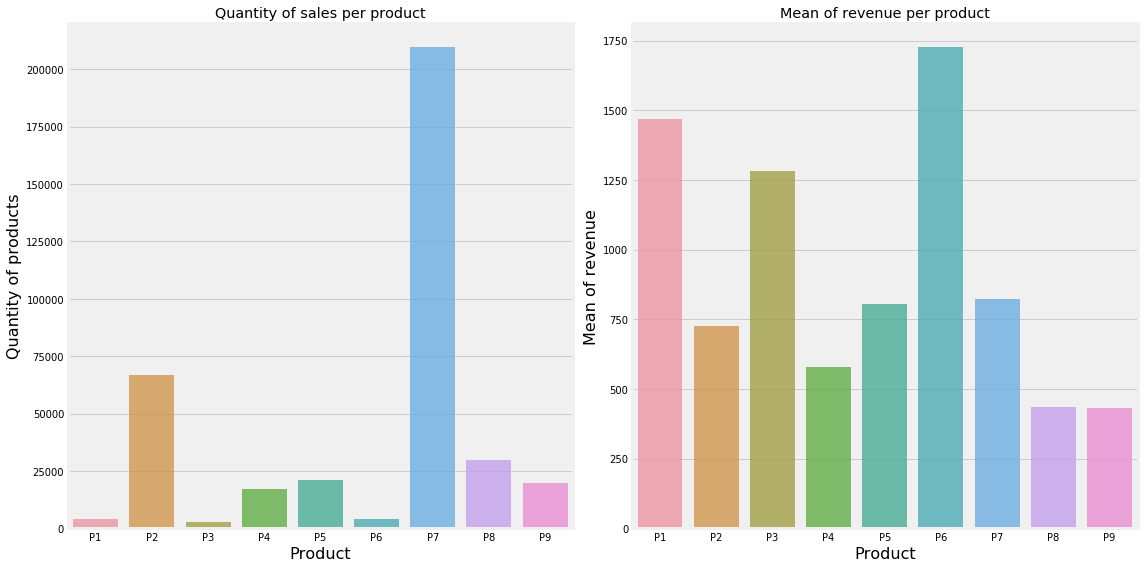

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.barplot(sales_per_item.index, sales_per_item['qty_order'], alpha=0.8, ax=ax[0])
ax[0].set_title('Quantity of sales per product')
ax[0].set_xlabel('Product', fontsize=16)
ax[0].set_ylabel('Quantity of products', fontsize=16)

sns.barplot(revenue_per_item.index, revenue_per_item['revenue'], alpha=0.8, ax=ax[1])
ax[1].set_title('Mean of revenue per product')
ax[1].set_xlabel('Product', fontsize=16)
ax[1].set_ylabel('Mean of revenue', fontsize=16)

plt.tight_layout();

We can see that product P7 is the one that sales the most but is not the one with the biggest revenue, this one is the product P6 which is one of the lowests products that has been sold on this period. 

So it gives us that product P6 is the more expensive product we have for sale together with product P1 and P3, which are the top 3 products with more revenue and lowest quantity of sales.

If I can suggest something, just based on these graphs, is to start to sales more products P1, P3 and P6 since it's the most expensive products we have.

In [250]:
prices.head()

,prod_id,competitor,competitor_price,pay_type
date_extraction,,,,
2015-01-01 08:10:25,P7,C4,799.000,1
2015-01-01 08:10:25,P6,C6,2799.900,1
2015-01-01 08:10:25,P6,C1,1959.900,1
2015-01-01 08:10:25,P6,C3,1914.900,1
2015-01-01 08:10:25,P6,C1,1959.900,2


In [21]:
prices_per_item = prices.groupby(['prod_id'])['competitor_price'].sum().to_frame()
prices_per_item.sort_values(by='prod_id', ascending=True, inplace=True)

prices_per_competitor = prices.groupby(['competitor'])['competitor_price'].sum().to_frame()
prices_per_competitor.sort_values(by='competitor', ascending=True, inplace=True)

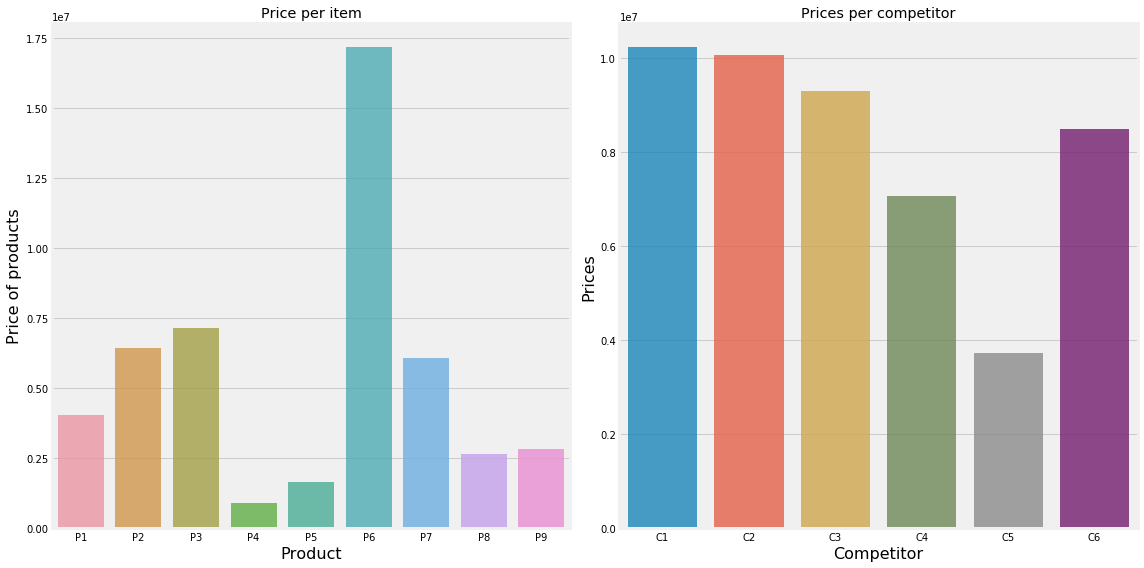

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.barplot(prices_per_item.index, prices_per_item['competitor_price'], alpha=0.8, ax=ax[0])
ax[0].set_title('Price per item')
ax[0].set_xlabel('Product', fontsize=16)
ax[0].set_ylabel('Price of products', fontsize=16)

sns.barplot(prices_per_competitor.index, prices_per_competitor['competitor_price'], alpha=0.8, ax=ax[1])
ax[1].set_title('Prices per competitor')
ax[1].set_xlabel('Competitor', fontsize=16)
ax[1].set_ylabel('Prices', fontsize=16)

plt.tight_layout();

We can see that product P6 is the most expensive product that our competitors sell and that competitor C1 is the biggest competitor we have and C5 is the lowest.

The expensiveness of P6 is in agreement with our analysis of the sales dataset. P6 is in fact the more expensive product that us and our competitors' have.

The top 3 competetitors' with biggest prices was C3, C2 and the biggest C1.

Let's give a look into the sold quantities of all products sales over time.

In [45]:
sales[sales['prod_id'] == 'P1'].resample('D')['qty_order'].sum().isnull().sum()

0

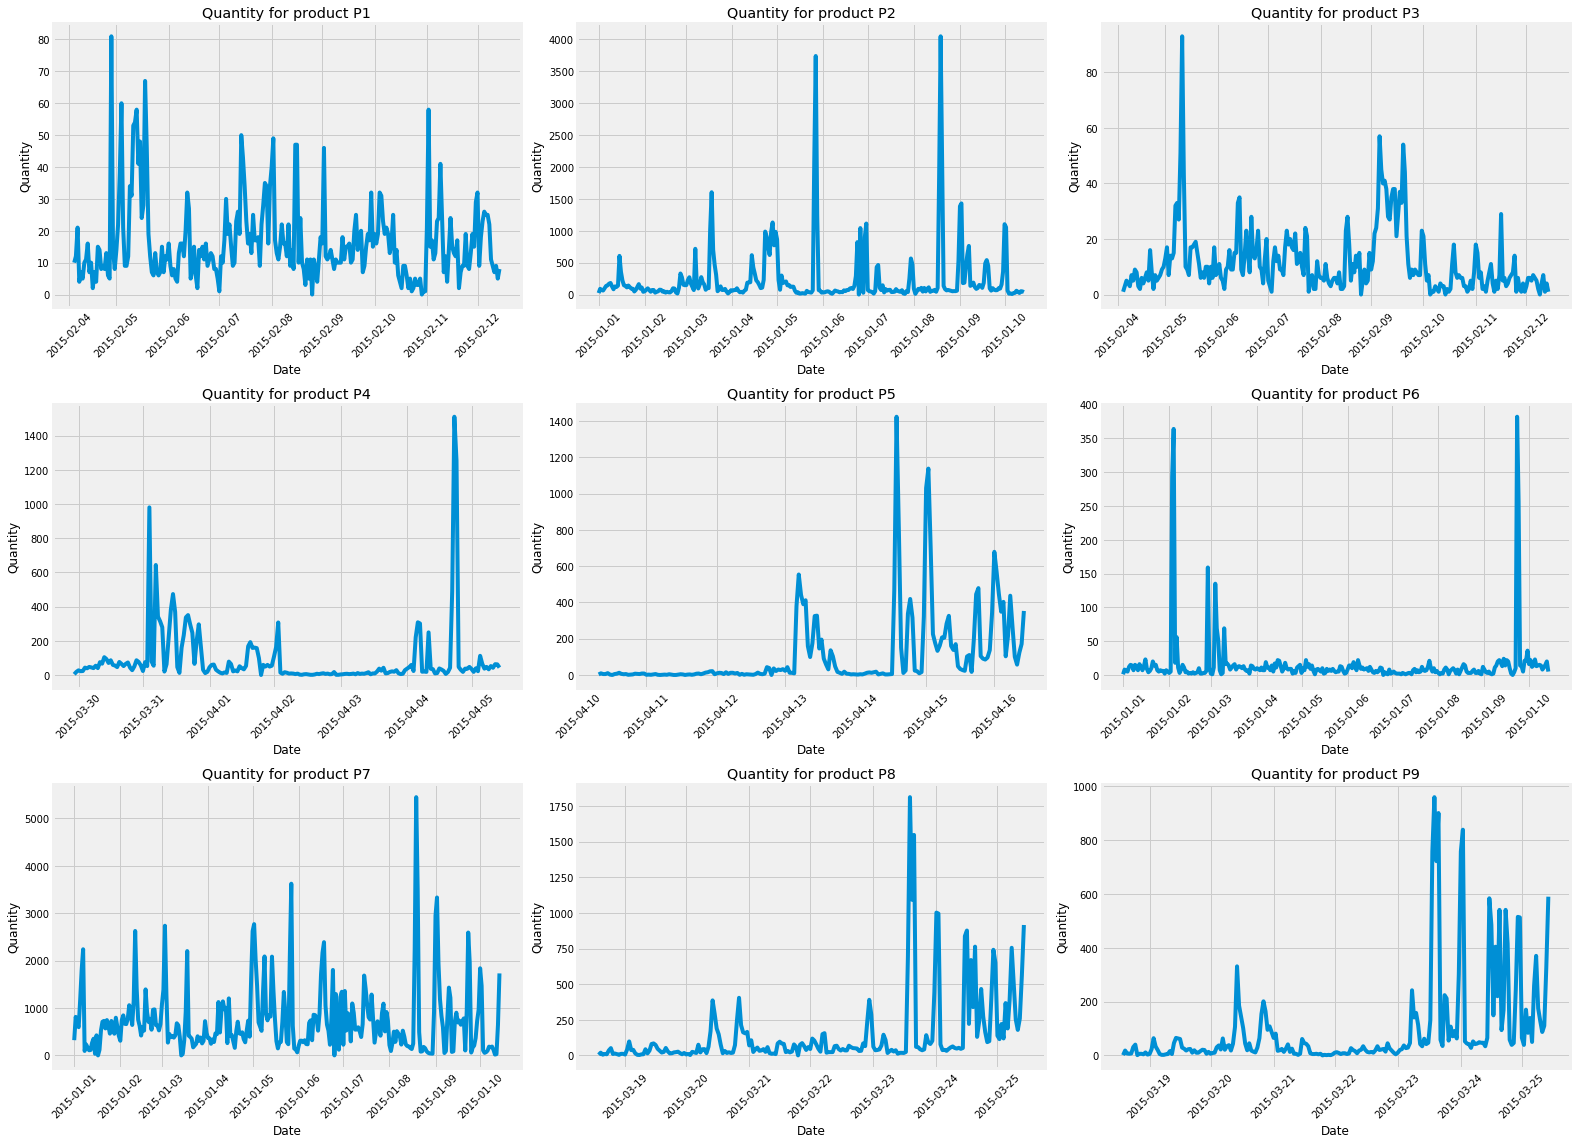

In [58]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]
        ts = ts.resample('D').sum()['qty_order']
        
        ax[i,j].plot(ts.index, ts)
        ax[i,j].set_title('Quantity for product {}'.format(products[k]))
        ax[i,j].set_xlabel('Date')
        ax[i,j].set_ylabel('Quantity')
        ax[i,j].set_xticklabels(ts.index.astype(str), rotation=45)
        
        k+=1
            
        plt.tight_layout()

And now on it's revenue

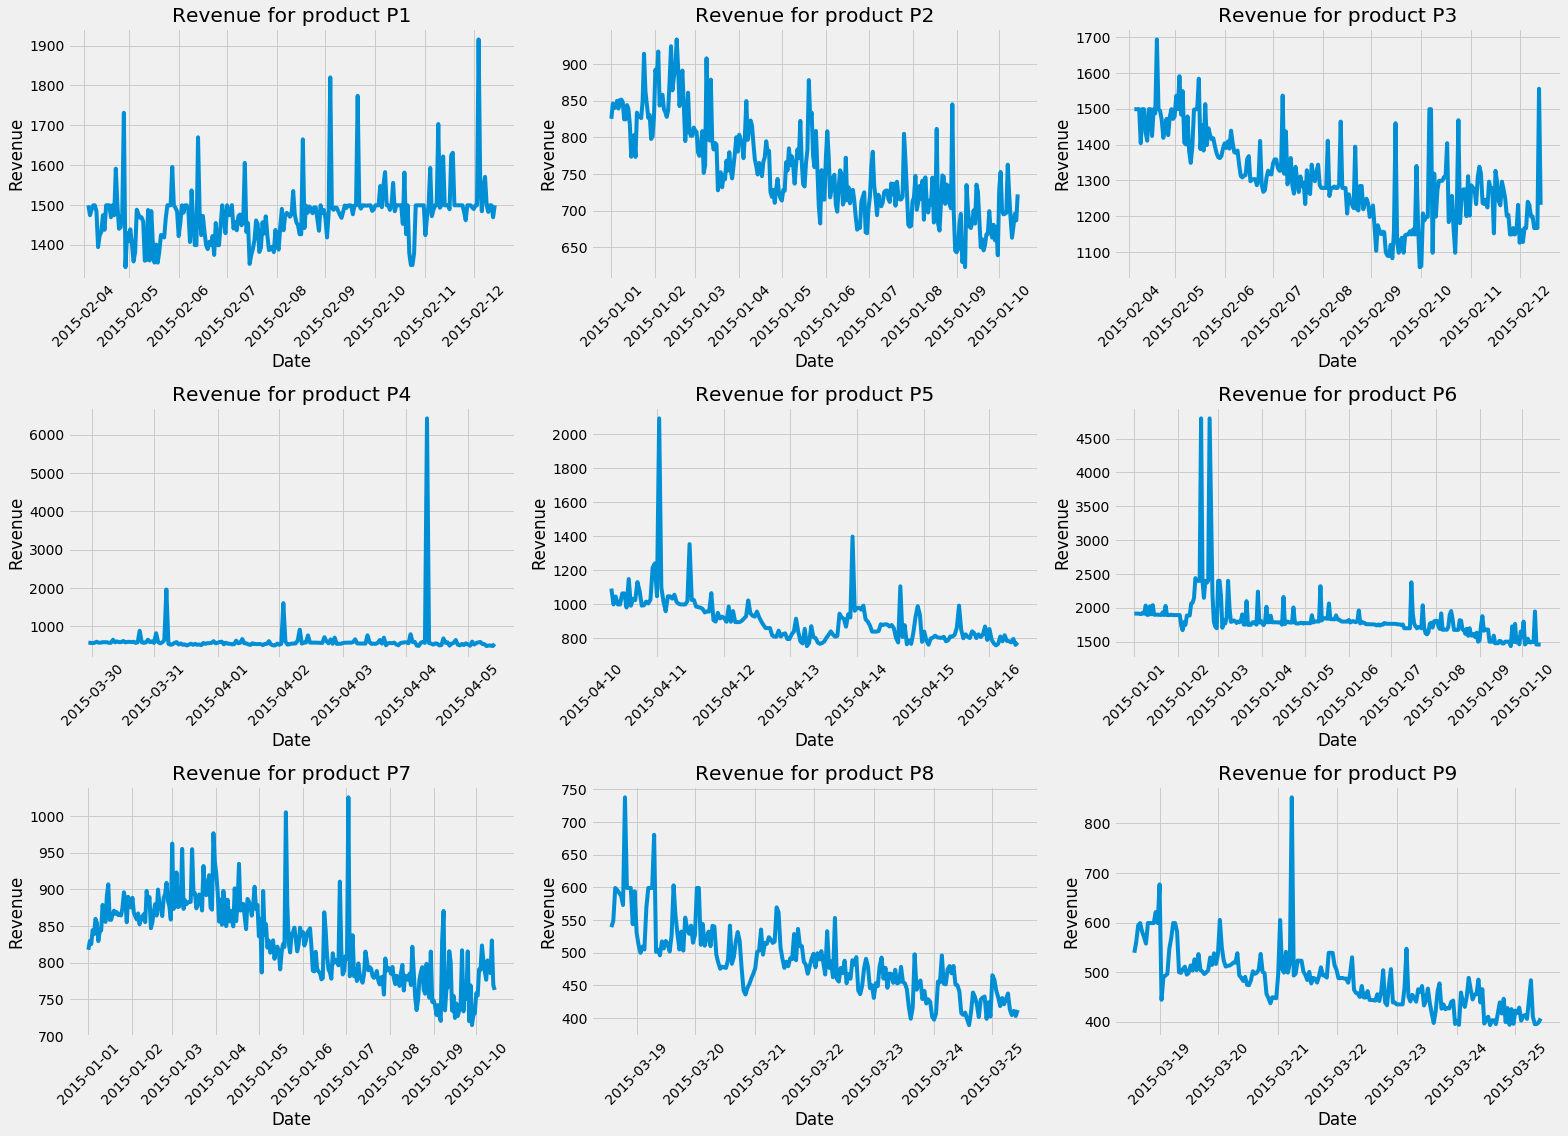

In [251]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]['revenue']
        ts = ts.resample('D').mean()
        ts.fillna(method='ffill', inplace=True)
        
        ax[i,j].plot(ts.index, ts)
        ax[i,j].set_title('Revenue for product {}'.format(products[k]))
        ax[i,j].set_xlabel('Date')
        ax[i,j].set_ylabel('Revenue')
        ax[i,j].set_xticklabels(ts.index.astype(str), rotation=45)

        k+=1
            
        plt.tight_layout()

The objective is to forecast the quantity of sales for each product. Sales over time for each product is a time series for itself so before we handle all of the products let's deal with only one ime series and try to undestand it.

In [60]:
p7 = sales[sales['prod_id'] == 'P7'][['qty_order', 'revenue']]

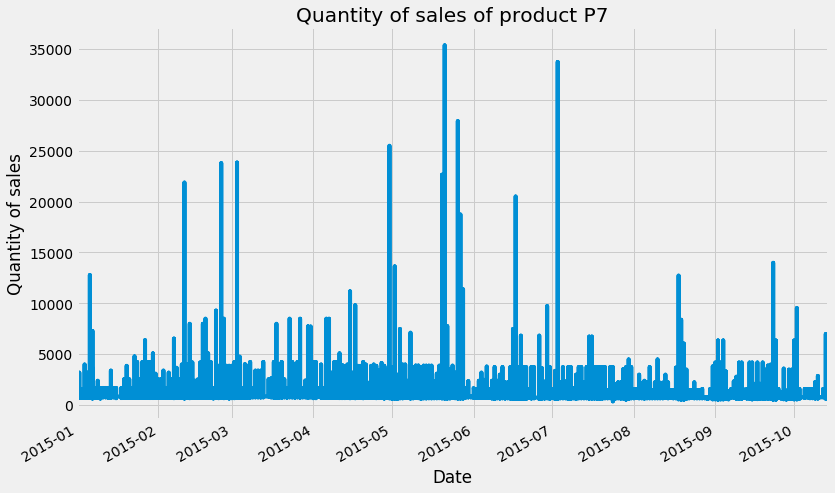

In [252]:
p7['revenue'].plot(figsize=(12, 8))
plt.title('Quantity of sales of product P7')
plt.xlabel('Date')
plt.ylabel('Quantity of sales');

Let's resample the time series per day to see it more clearly and plot it together with it's rolling mean and standart deviation.

In [28]:
sales_per_day = p7.resample('D').agg({'qty_order': 'sum', 'revenue': 'mean'})

In [161]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


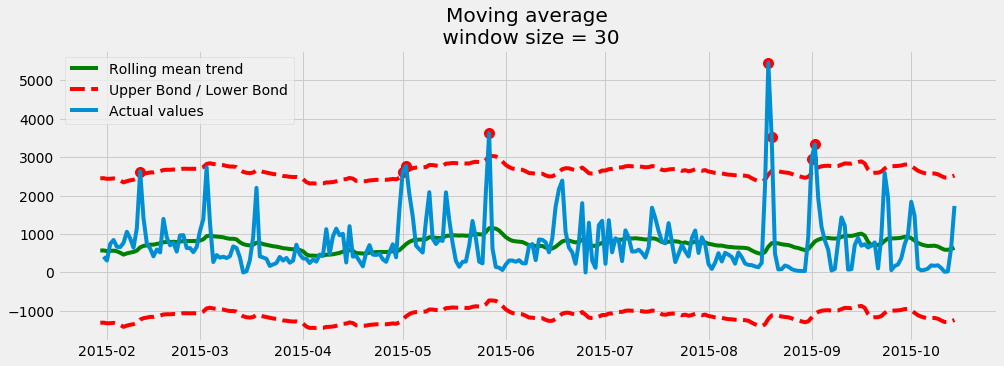

In [166]:
plotMovingAverage(sales_per_day['qty_order'].to_frame(), window=30, plot_intervals=True, plot_anomalies=True)

In [158]:
def plot_ts(ts, window=30, label='Product quantity', 
            title='Quantity of sales of product P1', xlabel='Date', 
            ylabel='Quantity of sales', confidence_interval=False, anomalie_detection=False, threshold=1.96):
    
    """
    This function plot the time series data and it's rolling statistics.
    param ts: Time series data
    param window: Time window to use on rolling statistics
    param label: Label to put in your time series plot
    param title: Title to put in your time series plot
    param xlabel: X-axis label to put in your time series plot.
    param ylabel: Y-axis label to put in your time series plot.
    para confidence_interval: To plot the confidence interval with 95% of confidence or not.
    param threshold: Threshold to get a 95% of confidence.
    return: It returns a plt figure.
    """
    if confidence_interval:
        
        rol_mean = ts['qty_order'].rolling(window=window).mean()
        rol_std = ts['qty_order'].rolling(window=window).std()
        
        upper_bound = rol_mean + threshold*rol_std
        lower_bound = rol_mean - threshold*rol_std
        
        plt.figure(figsize=(12, 8))
        plt.plot(ts.index, ts['qty_order'])
        plt.plot(upper_bound.index, upper_bound, linestyle='--')
        plt.plot(lower_bound.index, lower_bound, linestyle='--')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['Original', 'Upper Confidence Band', 'Lower Confidence Band'])
        
        if anomalie_detection:
            anomalies = pd.DataFrame(index=ts.index, columns=ts.columns)
            anomalies[ts>upper_bound] = ts[ts>upper_bound]
            anomalies[ts<lower_bound] = ts[ts<lower_bound]
            plt.plot(anomalies, 'o-', markersize=10)
    
    else:
        
        rol_mean = ts['qty_order'].rolling(window=window).mean()
        rol_std = ts['qty_order'].rolling(window=window).std()
        
        plt.figure(figsize=(12, 8))
        plt.plot(ts.index, ts['qty_order'])
        plt.plot(rol_mean.index, rol_mean)
        plt.plot(rol_std.index, rol_std)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['Original', 'Rolling Mean', 'Rolling Mean'])
    
    return plt

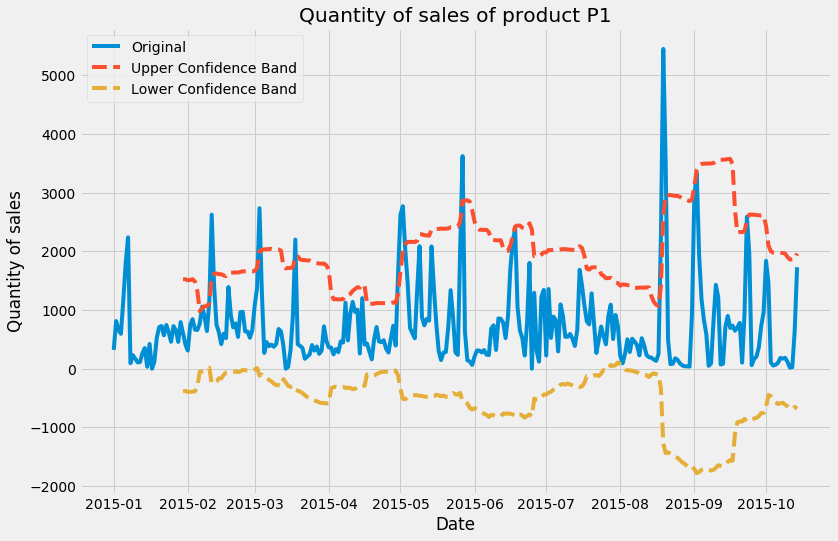

In [168]:
_ = plot_ts(sales_per_day['qty_order'].to_frame(), confidence_interval=True, anomalie_detection=True)

Let's decompose the time series for this product in trend, seasonality and residual components.

In [94]:
def decompose_ts(ts, freq=30, model='additive'):
    """
    This function decomposes a time series in a trend, seasonal and residual components and plots it's components.
    
    param ts: Time series data
    param freq: Frequency for decomposition
    param model: Model for the time series
    returns: It returns it's residual components.
    
    """
    res = sm.tsa.seasonal_decompose(ts.values, freq=freq, model=model)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    ax[0,0].plot(ts.index, res.observed)
    ax[0,0].set_title('Original Time Series')
    ax[0,0].set_xticklabels(labels=ts.index.astype(str), rotation=45)
    ax[0,1].set_title('Trend')
    ax[0,1].plot(ts.index, res.trend)
    ax[0,1].set_xticklabels(labels=ts.index.astype(str), rotation=45)
    ax[1,0].plot(ts.index, res.seasonal)
    ax[1,0].set_title('Seasonality')
    ax[1,0].set_xticklabels(labels=ts.index.astype(str), rotation=45)
    ax[1,1].plot(ts.index, res.observed)
    ax[1,1].set_title('Residual')
    ax[1,1].set_xticklabels(labels=ts.index.astype(str), rotation=45)
    plt.tight_layout()
    
    return res

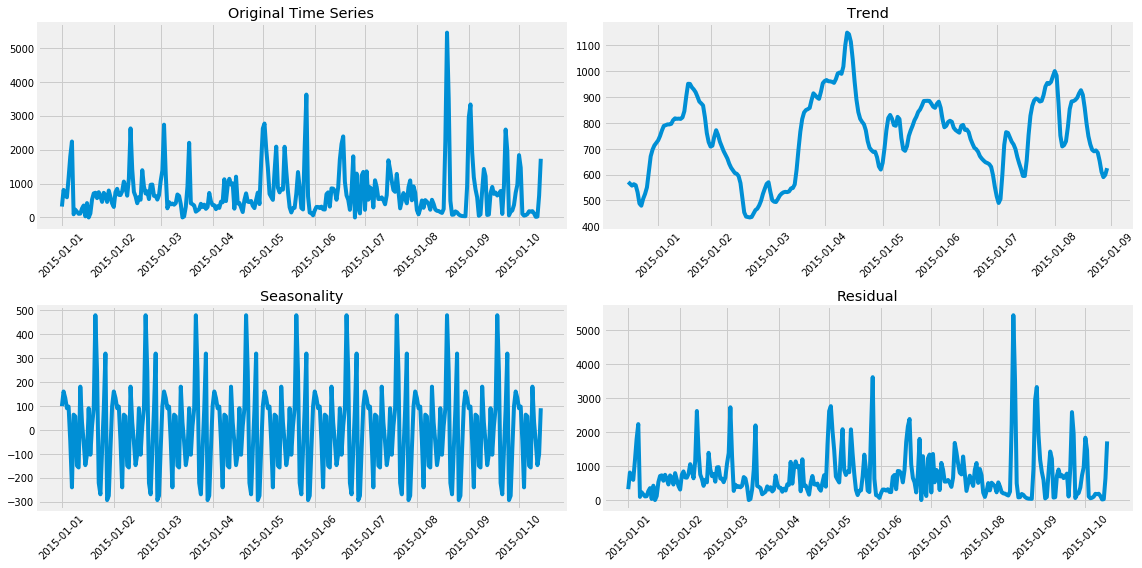

In [95]:
res = decompose_ts(sales_per_day['qty_order'])

The trend part of the time series don't give us a lot of information but we can see that don't exists a clear seasonality on our data, let's look it further by plotting the autocorrelation function.

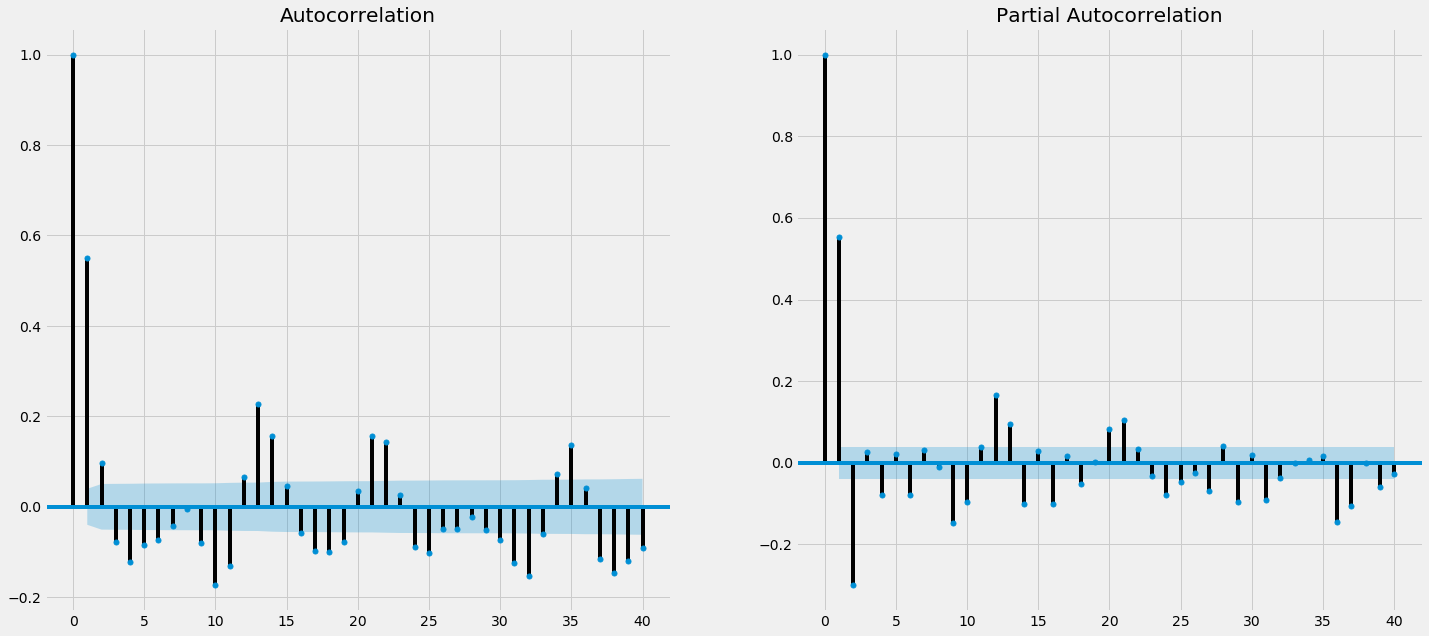

In [213]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

plot_acf(sales_per_day['qty_order'], lags=40, ax=ax[0], alpha=0.5)
plot_pacf(sales_per_day['qty_order'], lags=40, ax=ax[1], alpha=0.5);

Let's take a look on the data resample by month to see if we can some insights.

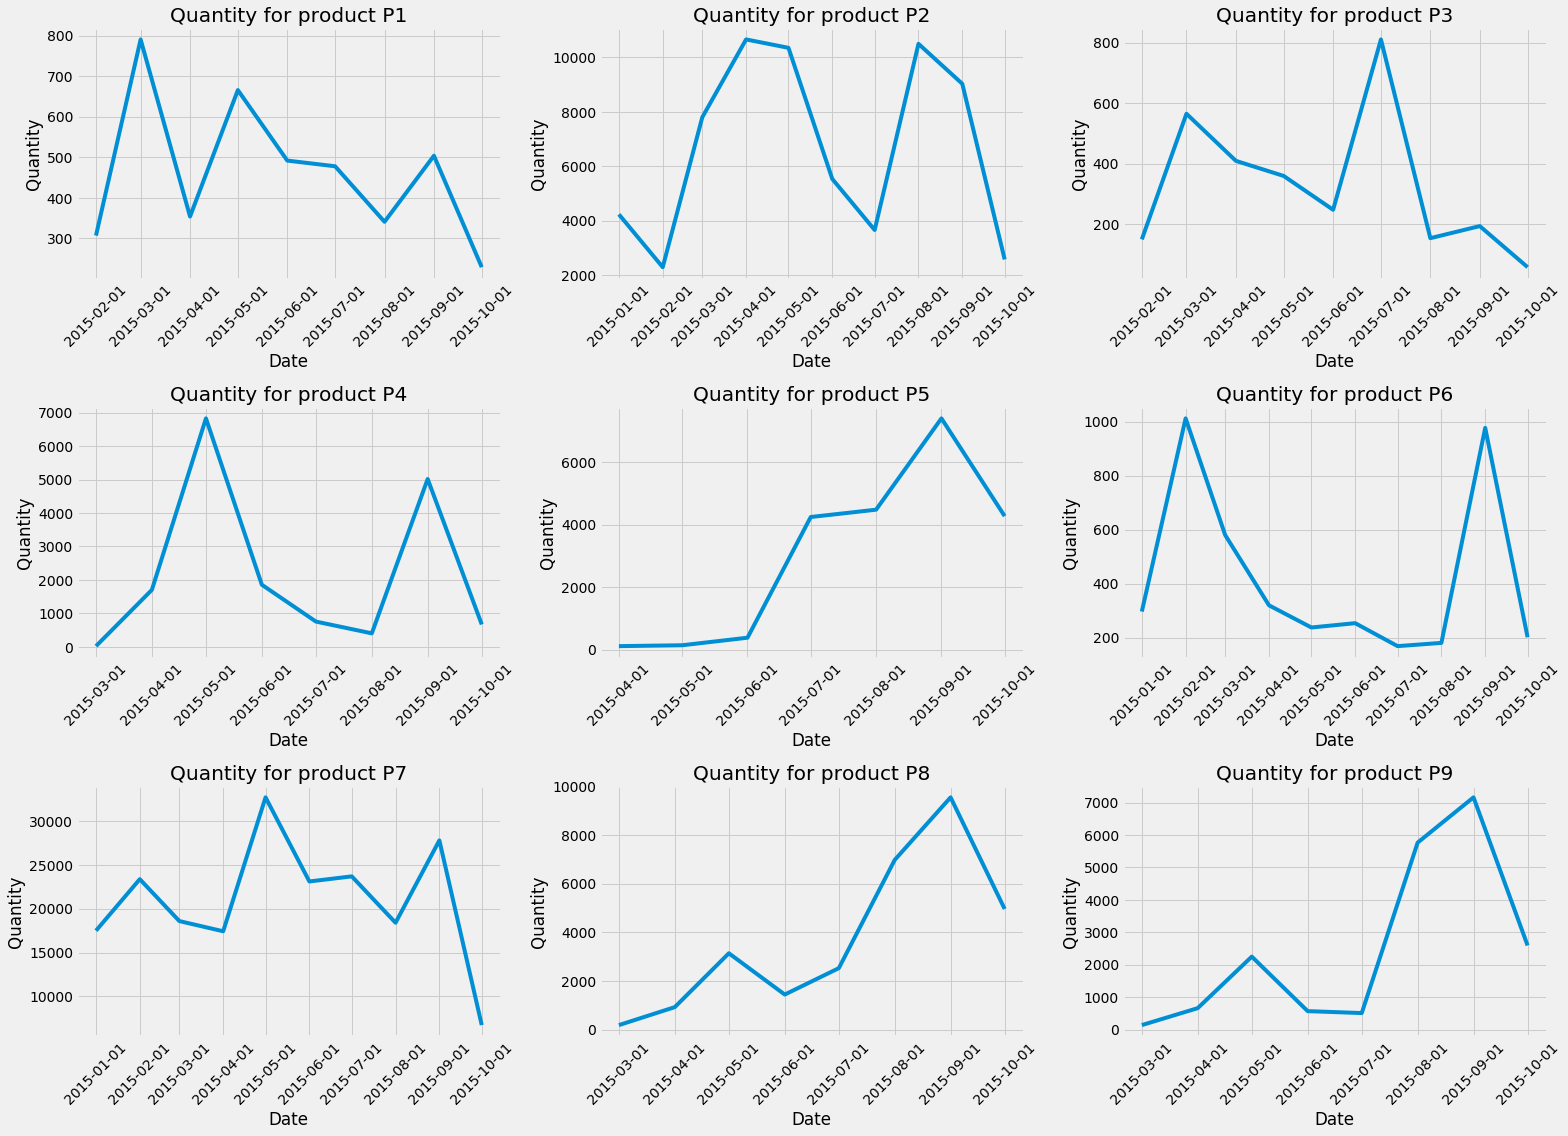

In [171]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]['qty_order']
        ts = ts.resample('MS').sum()
        
        ax[i,j].plot(ts.index, ts)
        ax[i,j].set_title('Quantity for product {}'.format(products[k]))
        ax[i,j].set_xlabel('Date')
        ax[i,j].set_ylabel('Quantity')
        ax[i,j].set_xticklabels(ts.index.astype(str), rotation=45)

        k+=1
            
        plt.tight_layout()

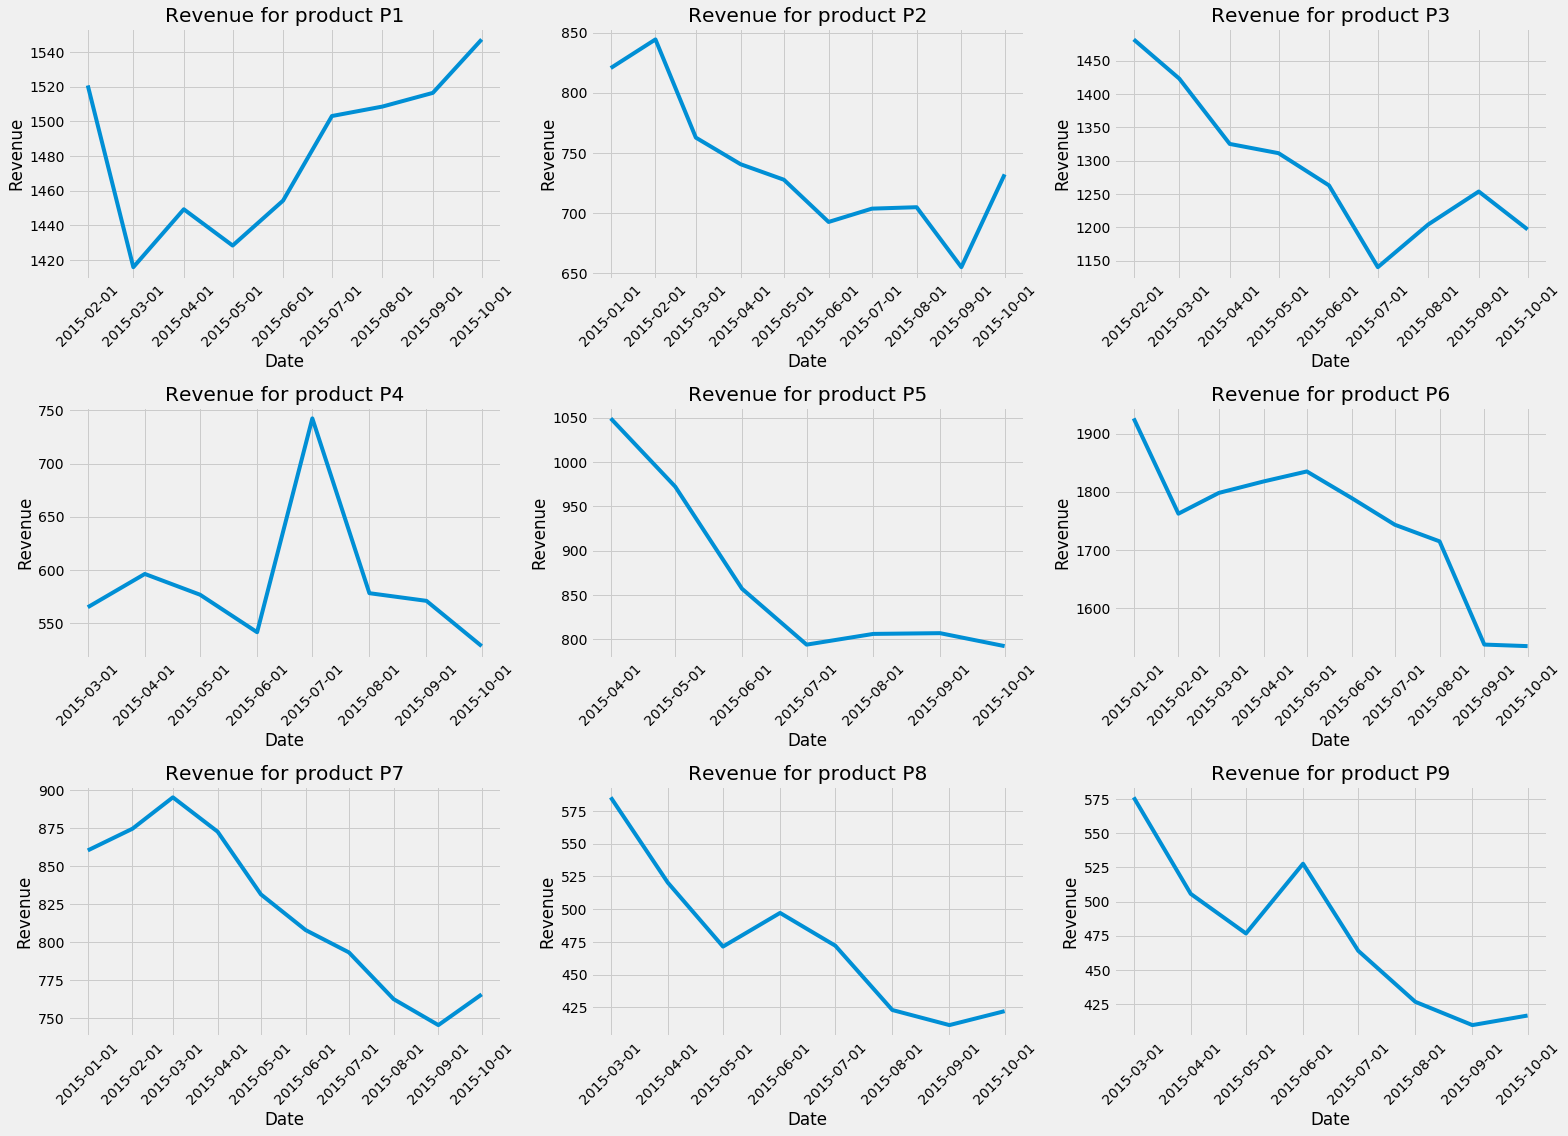

In [118]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(22, 16))

products = sales['prod_id'].sort_values().unique()
k = 0
for i in range(3):
    for j in range(3):
        ts = sales[sales['prod_id'] == products[k]]['revenue']
        ts = ts.resample('MS').mean()
        
        ax[i,j].plot(ts.index, ts)
        ax[i,j].set_title('Revenue for product {}'.format(products[k]))
        ax[i,j].set_xlabel('Date')
        ax[i,j].set_ylabel('Revenue')
        ax[i,j].set_xticklabels(ts.index.astype(str), rotation=45)
        
        k+=1
            
        plt.tight_layout()

As we can see there's a clearly tendency of decay on revenue on almost every product, excluding product P1.

Let's check now if the series is stationary, for stationary we mean that all the statistical properties(mean, variance and covariance) of out time series don't change over time. 
We want to check this because most of statistical forecasting methods assume that our data is stationary.

To do that we use a statistical hypothesis test called Dickey Fuller Test for stationarity.

In [243]:
def test_stationarity(ts):
    """
    Performs a dickey fuller test to check stationarity of a time series.
    
    param ts: Time series data
    return: Output of the test as a dataframe.
    
    """
#     print('Performing Dickey Fuller test..')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns=['Statistical Values'])
    
    for key, value in dftest[4].items():
        dfoutput.loc['Critical value {}'.format(key)] = value
    
    return dfoutput

In [244]:
output = test_stationarity(sales_per_day['qty_order'])
output

,Statistical Values
Test Statistic,-4.306
p-value,0.000
#Lags Used,13.000
Number of Observations Used,273.000
Critical value 1%,-3.455
Critical value 5%,-2.872
Critical value 10%,-2.572


As we can see, we have test statistics lower than the critical value for 1% so we can say with 99% of certainty that our series is stationary.

Let's see if there's a correlation between the two datasets

In [180]:
competitors = prices['competitor'].sort_values().unique()
competitor_prod = prices.groupby(['competitor', 'prod_id']).mean()['competitor_price'].to_frame()

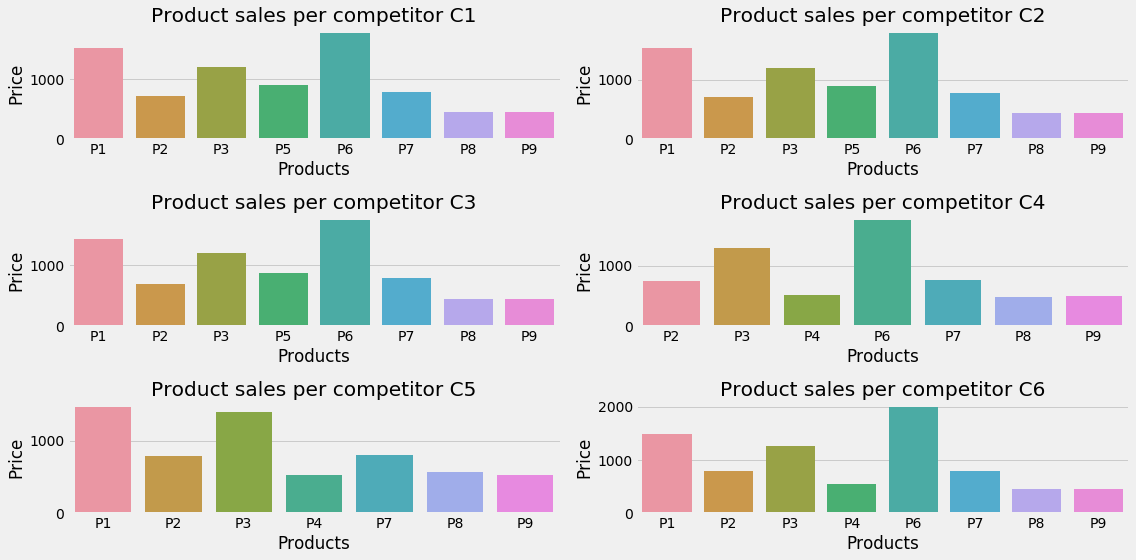

In [247]:
fig, ax = plt.subplots(nrows=3, ncols=2)

k = 0
for i in range(3):
    for j in range(2):
        sns.barplot(x=competitor_prod.loc[competitors[k]].index, y=competitor_prod.loc[competitors[k]]['competitor_price'], ax=ax[i, j])
        ax[i, j].set_title('Product sales per competitor {}'.format(competitors[k]))
        ax[i, j].set_xlabel('Products')
        ax[i, j].set_ylabel('Price')
        k+=1
        plt.tight_layout()

In [184]:
sales['competitor_price_per_prod'] = sales['prod_id'].map(prices.groupby('prod_id')['competitor_price'].mean().to_dict())
sales['competitor_per_prod'] = sales['prod_id'].map(prices.groupby('prod_id').count()['competitor'].to_dict())
sales['sales_month'] = sales.index.month

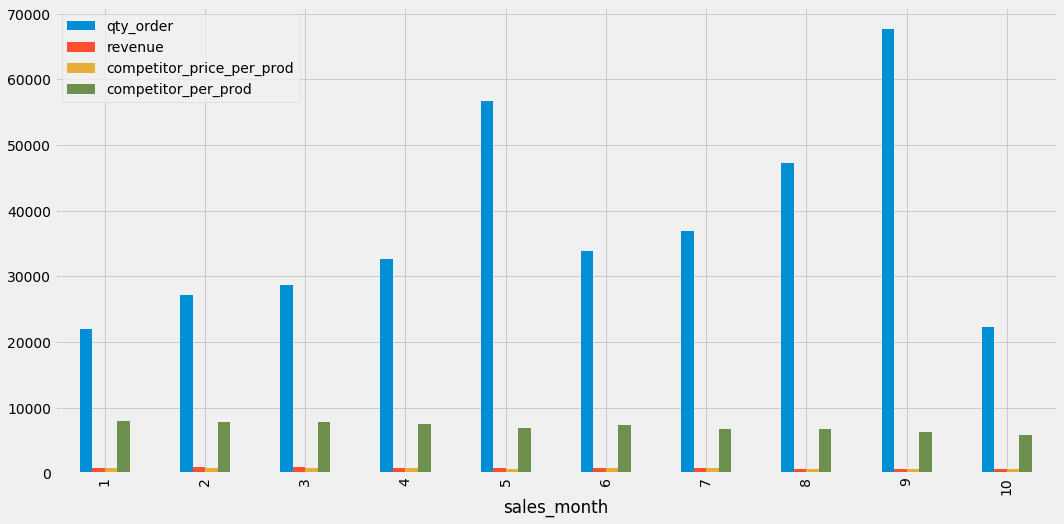

In [185]:
sales.groupby('sales_month').agg({'qty_order': 'sum', 'revenue': 'mean', 'competitor_price_per_prod': 'mean', 'competitor_per_prod': 'mean'}).plot(kind='bar')

In [256]:
df = sales.resample('D').agg({'qty_order': 'sum', 'revenue': 'mean', 'competitor_price_per_prod': 'mean', 'competitor_per_prod': 'mean'})

In [257]:
df['sales_month'] = df.index.month
df['sales_day'] = df.index.day
df['sales_day'] = df.index.day

In [258]:
df.head()

,qty_order,revenue,competitor_price_per_prod,competitor_per_prod,sales_month,sales_day
date_order,,,,,,
2015-01-01,345.000,821.278,784.346,7812.050,1,1
2015-01-02,910.000,840.749,789.078,7855.409,1,2
2015-01-03,737.000,835.883,788.596,7849.136,1,3
2015-01-04,663.000,852.458,787.972,7851.520,1,4
2015-01-05,1276.000,850.182,790.885,7834.376,1,5


In [260]:
df.fillna(method='ffill', axis=0, inplace=True)

In [261]:
df.corr()

,qty_order,revenue,competitor_price_per_prod,competitor_per_prod,sales_month,sales_day
qty_order,1.000,-0.264,-0.185,-0.043,0.246,0.004
revenue,-0.264,1.000,0.867,0.621,-0.777,-0.169
competitor_price_per_prod,-0.185,0.867,1.000,0.469,-0.520,-0.218
competitor_per_prod,-0.043,0.621,0.469,1.000,-0.720,0.063
sales_month,0.246,-0.777,-0.520,-0.720,1.000,-0.069
sales_day,0.004,-0.169,-0.218,0.063,-0.069,1.000


In [262]:
for s in range(1, 11):
    df['{}_shifted_quantity'.format(s)] = df['qty_order'].diff(s)

In [263]:
df.fillna(0.0, inplace=True)

In [264]:
df.head()

,qty_order,revenue,competitor_price_per_prod,competitor_per_prod,sales_month,sales_day,1_shifted_quantity,2_shifted_quantity,3_shifted_quantity,4_shifted_quantity,5_shifted_quantity,6_shifted_quantity,7_shifted_quantity,8_shifted_quantity,9_shifted_quantity,10_shifted_quantity
date_order,,,,,,,,,,,,,,,,
2015-01-01,345.000,821.278,784.346,7812.050,1,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-01-02,910.000,840.749,789.078,7855.409,1,2,565.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-01-03,737.000,835.883,788.596,7849.136,1,3,-173.000,392.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-01-04,663.000,852.458,787.972,7851.520,1,4,-74.000,-247.000,318.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-01-05,1276.000,850.182,790.885,7834.376,1,5,613.000,539.000,366.000,931.000,0.000,0.000,0.000,0.000,0.000,0.000


In [265]:
X = df.drop('qty_order', axis=1).values
y = df['qty_order'].values.reshape(-1,1)

In [266]:
n_days = 30

predictions = []
true_values = []
for i in reversed(range(1, n_days)):
    X_train = X[:len(X)-i]
    y_train = y[:len(y)-i]
    X_test = X[len(X)-i]
    y_test = y[len(y)-i]
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions.append(model.predict([X_test])[0])
    true_values.append(y_test[0])

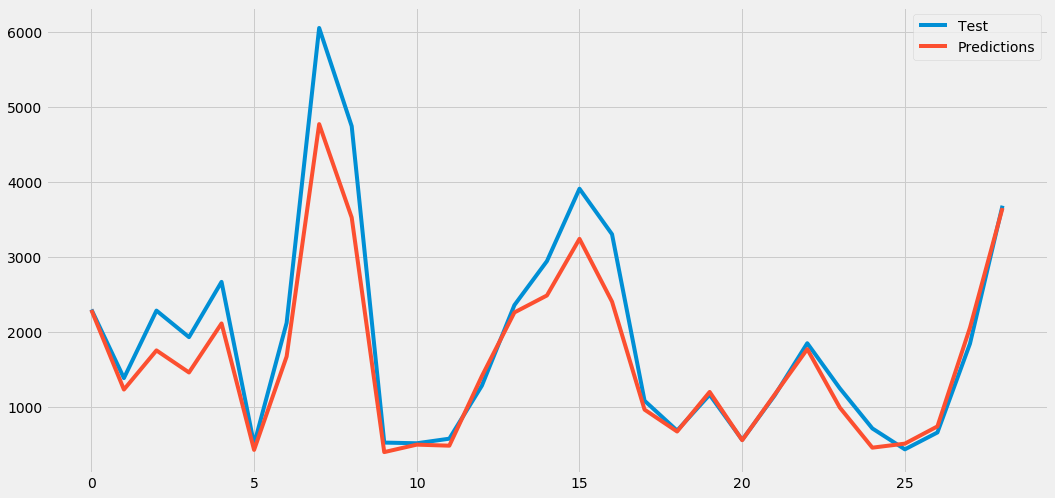

In [267]:
plt.plot(true_values)
plt.plot(predictions)
plt.legend(['Test', 'Predictions']);

In [268]:
def rmse(true, predictions): 
    """
    This functions calculate the root mean squared error of a predictions
    
    param true: True values of the data
    param predictions: Predicted values
    return: RMSE
    
    """
    true = np.array(true)
    predictions = np.array(predictions)
    return mean_squared_error(true, predictions) ** 0.5

def mape(true, predictions): 
    """
    This functions calculate the mean absolute percentage error.
    
    param true: True values of the data
    param predictions: Predicted values
    return: MAPE
    
    """
    true = np.array(true)
    predictions = np.array(predictions)    
    return np.mean(np.abs((true - predictions)) / true) * 100

def metrics(true, predictions):
    """
    This functions calculate several metrics of a regression problem.
    
    param true: True values of the data
    param predictions: Predicted values
    return: Metrics dataframe with all metrics of interest.
    
    """
    metrics = pd.DataFrame(columns=['Metric Value'])
    metrics.loc['MAE'] = mean_absolute_error(true, predictions)
    metrics.loc['RMSE'] = rmse(true, predictions)
    metrics.loc['R2'] = r2_score(true, predictions)
    metrics.loc['MAPE'] = mape(true, predictions)
    
    return metrics

In [269]:
metrics(true_values, predictions)

,Metric Value
MAE,289.788
RMSE,450.868
R2,0.894
MAPE,13.849
